In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

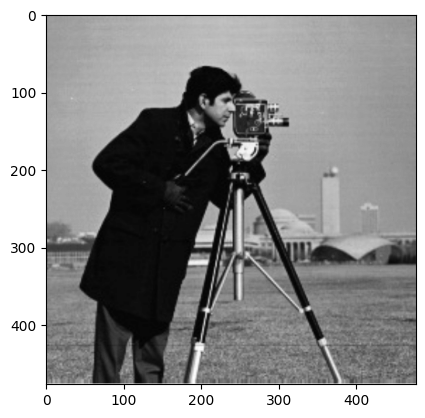

In [2]:
img = plt.imread("image.png")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

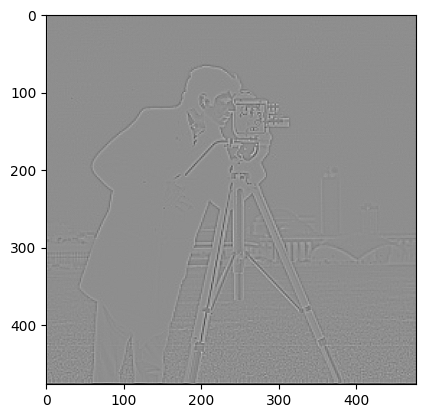

In [3]:
#
# ---- 1 Kantendetektion ----
#
#
#
# --- laplace ---
#
# cheaper to compute
laplace = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
    ])

plt.imshow(cv.filter2D(img_gray, -1, laplace), cmap="gray")

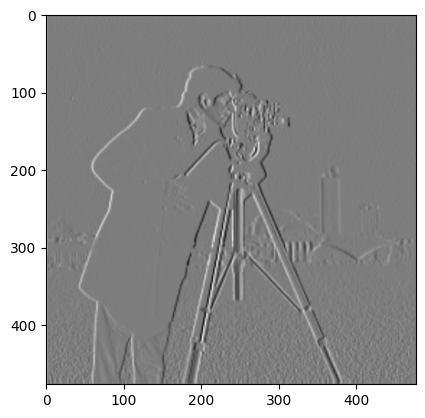

In [4]:
#
# --- sobel ---
#
# get orientation
sobel = 1/8 * np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

s1 = cv.filter2D(img_gray, -1, sobel)
plt.imshow(s1, cmap="gray")

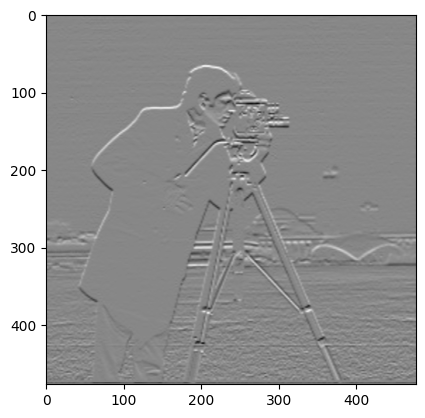

In [5]:
s2 = cv.filter2D(img_gray, -1, sobel.T)
plt.imshow(s2, cmap="gray")

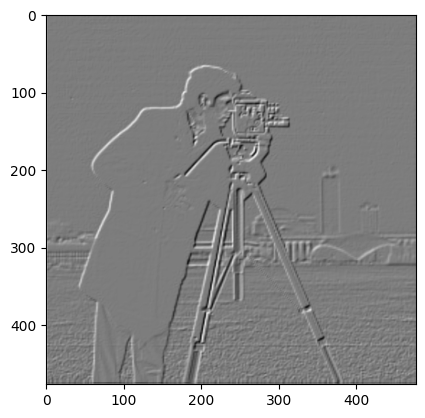

In [6]:
plt.imshow(cv.addWeighted(s1, 0.5, s2, 0.5, 0), cmap="gray")

In [7]:
#
# --- LoG filter ---
#
# works good irrespective of edge orientation
log = 1/16 * np.array([[0, 1, 2, 1, 0],
                          [1, 0, -2, 0, 1],
                          [2, -2, -8, -2, 2],
                          [1, 0, -2, 0, 1],
                          [0, 1, 2, 1, 0]])

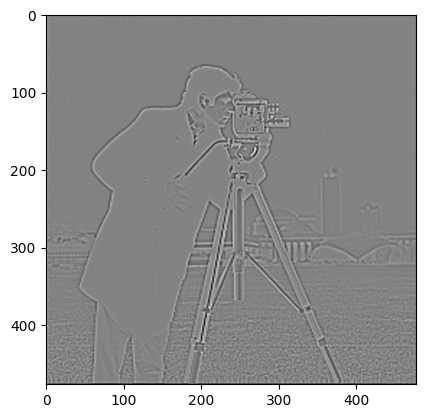

In [8]:
plt.imshow(cv.filter2D(img_gray, -1, log), cmap="gray")

In [9]:
#
# --- DoG filter ---
#
dog = np.array([[1, 4, 6, 4, 1],
                   [4, 0, -8, 0, 4],
                   [6, -8, -28, -8, 6],
                   [4, 0, -8, 0, 4],
                   [1, 4, 6, 4, 1]])

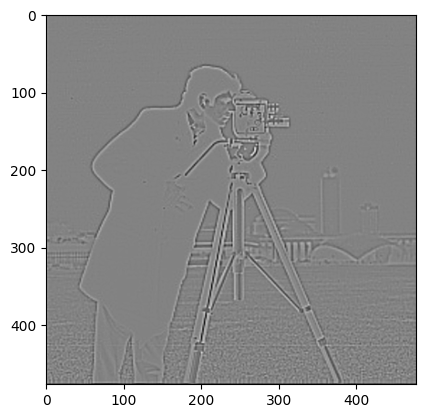

In [10]:
plt.imshow(cv.filter2D(img_gray, -1, dog), cmap="gray")

In [11]:
#
# ---  rescale ---
#
def scaled_filters(s=1):
    img_scaled = cv.resize(img_gray, tuple(map(lambda x: int(x//s**-1), img_gray.shape)))

    plt.imshow(cv.filter2D(img_scaled, -1, laplace), cmap="gray")
    plt.show()
    plt.imshow(cv.filter2D(img_scaled, -1, sobel), cmap="gray")
    plt.show()
    plt.imshow(cv.filter2D(img_scaled, -1, log), cmap="gray")
    plt.show()
    plt.imshow(cv.filter2D(img_scaled, -1, dog), cmap="gray")
    plt.show()

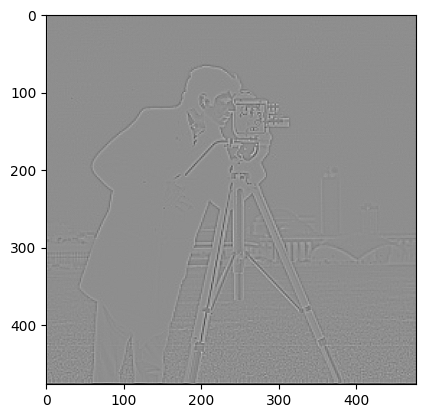

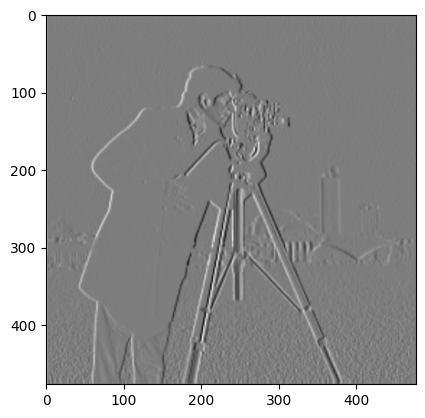

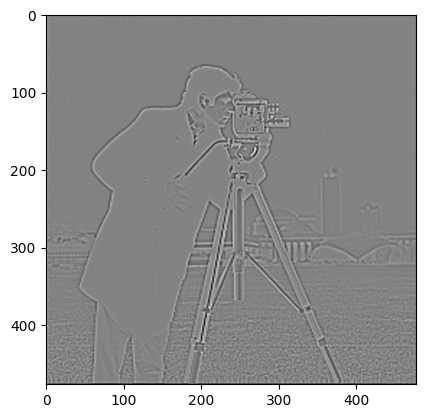

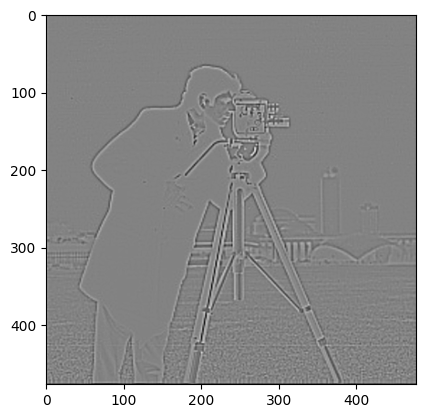

In [12]:
scaled_filters(1)

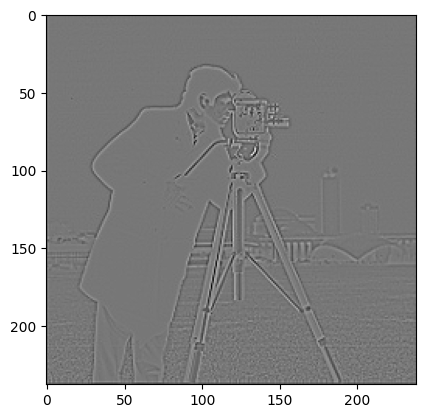

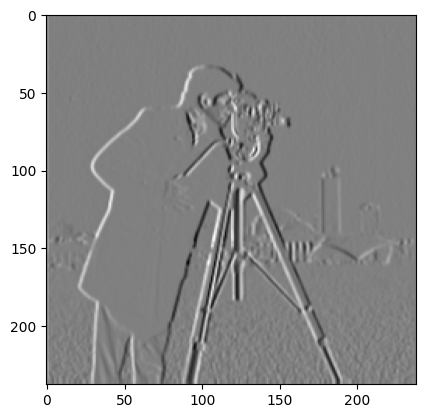

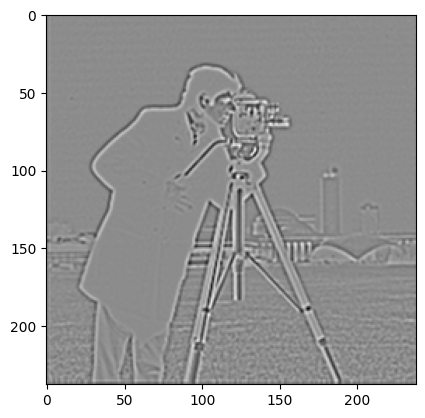

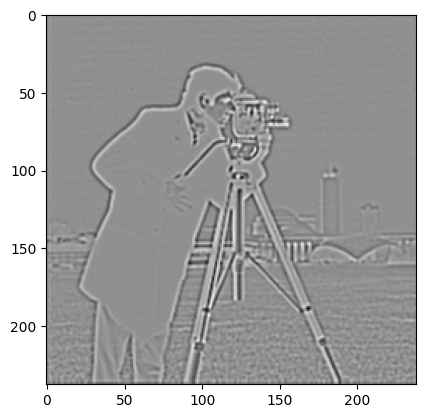

In [13]:
# down scale: focus on thick edges
scaled_filters(0.5)

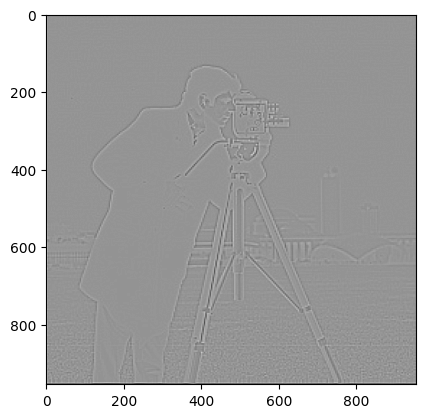

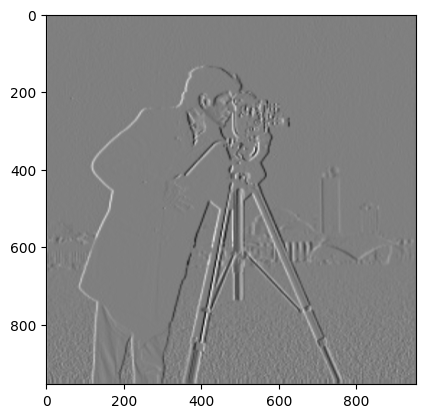

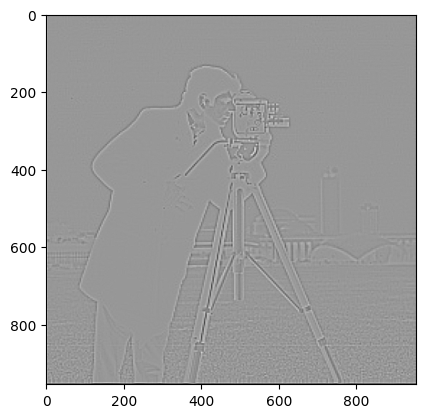

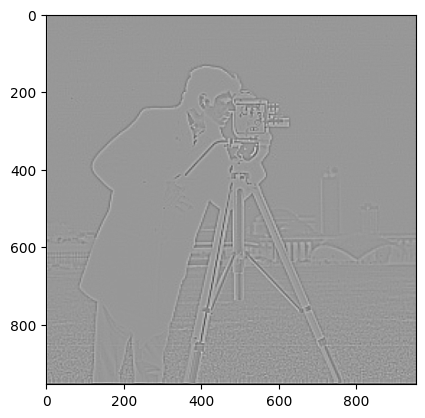

In [14]:
# up scale: focus on thinner edges
scaled_filters(2)

In [15]:
#
# ---- 2 Gauss Laplace Pyramide ----
#
def generate_gaussian_filter(size = 3):
    gaussian_filter = np.zeros((size, size))
    n = size//2
    sigma = n

    # generating the filter
    for y in range(-n, n+1):
        for x in range(-n, n+1):
            normal = 1 / (2.0 * np.pi * sigma**2.0)
            exp_term = np.exp(-(x**2.0 + y**2.0) / (2.0 * sigma**2.0))
            gaussian_filter[y+n, x+n] = normal * exp_term
    return gaussian_filter / gaussian_filter.sum()


gauss = generate_gaussian_filter()

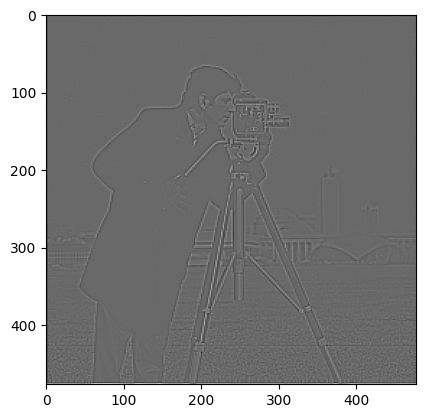

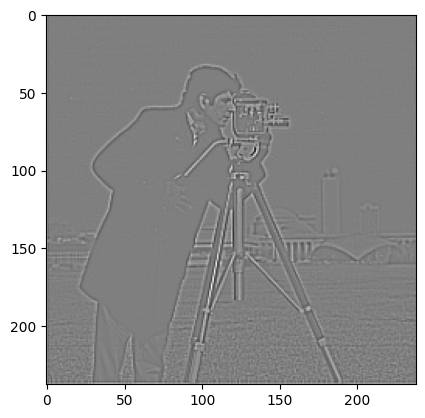

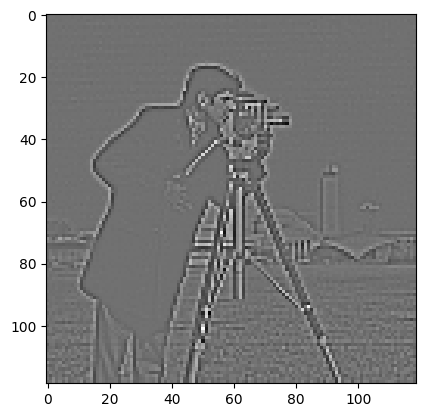

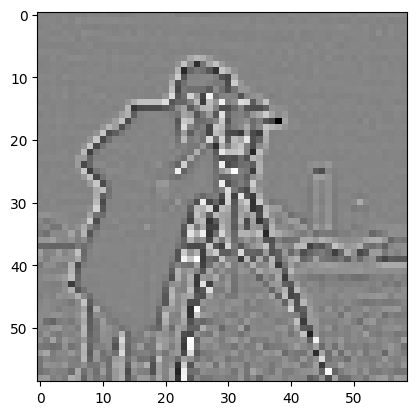

In [16]:
def scale(img, s):
    return cv.resize(img, tuple(
        map(lambda x: int(x//s**-1), img.shape)), fx=1, fy=1)
    
# compression result: 0.25 scaled image and laplace pyramid
scales=[1.0, 0.5, 0.25, 0.125]
shapes = []
scaled_laplace = []
for s in scales:
    img_scaled = scale(img_gray, s)
    shapes.append(img_scaled.shape)
    img_gauss = cv.filter2D(img_scaled, -1, gauss)
    assert img_scaled.shape == img_gauss.shape
    img_laplace = img_scaled - img_gauss
    scaled_laplace.append(img_laplace)
    plt.imshow(img_laplace, "gray")
    plt.show()

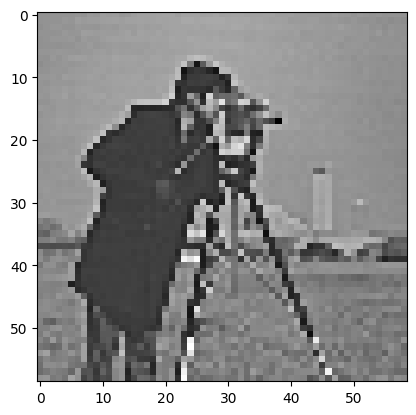

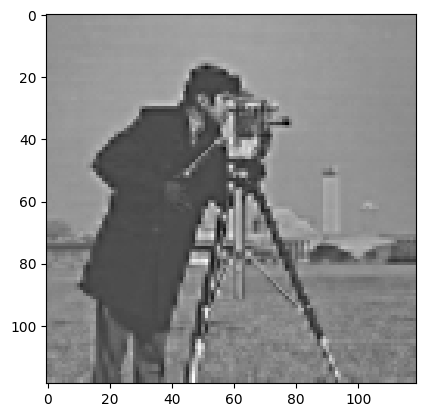

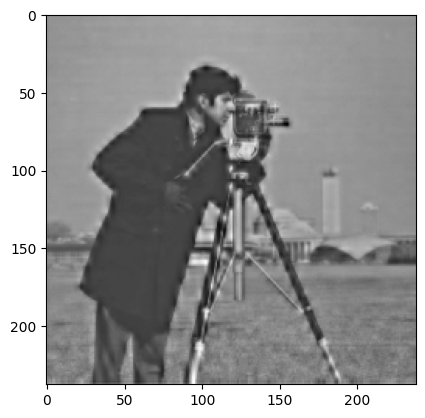

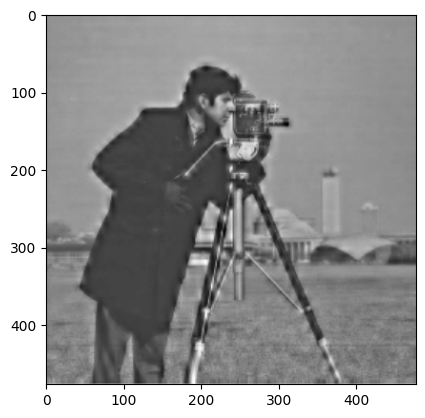

In [17]:
# reassemble from laplace pyramid
img_small = scale(img_gray, scales[-1])
for i in range(len(scales)):
    img_new = cv.resize(img_small, shapes[-i-1], fx=1, fy=1) + scaled_laplace[-i-1]
    img_small = img_new
    plt.imshow(img_small, "gray")
    plt.show()

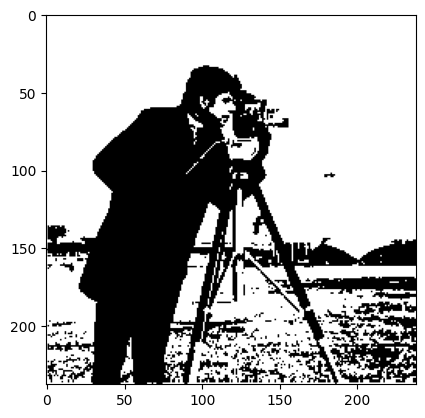

In [18]:
#
# ---- 3 Dilatation und Erosion ----
#
#img_bin = cv.threshold(img_gray,0.5,1,cv.THRESH_BINARY)
img_bin = scale(img_gray, 0.5)
img_bin = (img_bin > np.mean(img_bin)).astype(np.uint8)
img_bin_inv = (img_bin != 1).astype(np.uint8)
plt.imshow(img_bin, "gray")

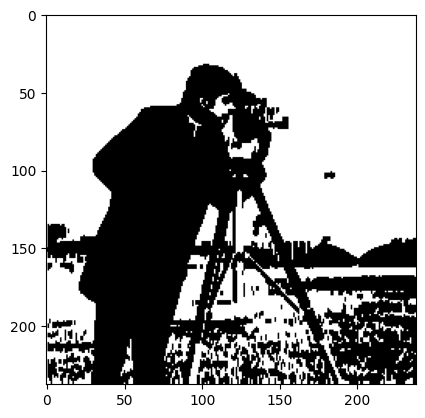

In [19]:
# erode
kernel = np.array([1, 1, 1])
img_erosion = cv.erode(img_bin, kernel, iterations=1)
plt.imshow(img_erosion, "gray")

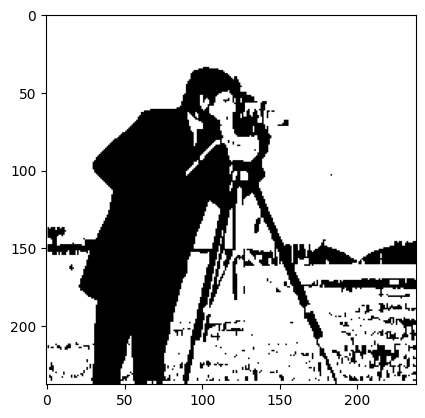

In [20]:
# dilate
kernel = np.array([1, 1, 1])
img_dilation = cv.dilate(img_bin, kernel, iterations=1)
plt.imshow(img_dilation, "gray")

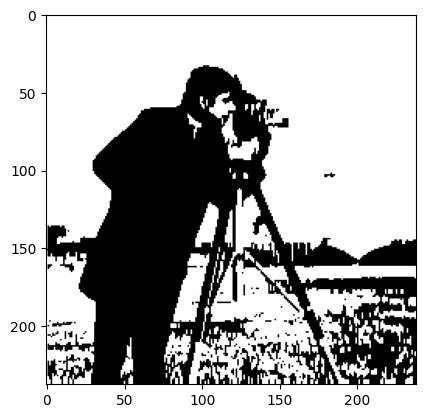

In [21]:
# opening
img_opening = cv.erode(img_bin, kernel, iterations=1)
img_opening = cv.dilate(img_opening, kernel, iterations=1)
plt.imshow(img_opening, "gray")

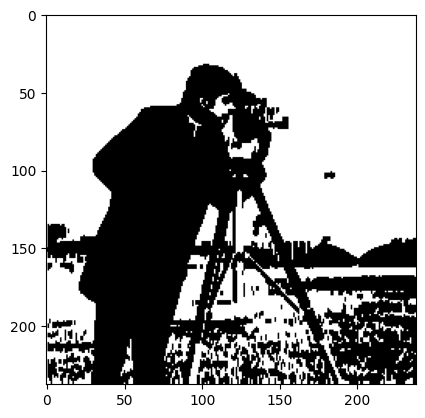

In [22]:
# closing
img_closing = cv.dilate(img_bin, kernel, iterations=1)
img_closing = cv.erode(img_opening, kernel, iterations=1)
plt.imshow(img_closing, "gray")

In [23]:
#
# ---- 4 Ausdünnung ----
#
def thin(img):
    kernel1 = np.array((
            [[-1, -1, -1],
            [0, 1, 0],
            [1, 1, 1]]))
    kernel2 = np.array((
            [[0, -1, -1],
            [1, 1, -1],
            [0, 1, 0]]))

    kernel3 = np.rot90(kernel1)
    kernel4 = np.rot90(kernel2)
    kernel5 = np.rot90(np.rot90(kernel1))
    kernel6 = np.rot90(np.rot90(kernel2))
    kernel7 = np.rot90(np.rot90(np.rot90(kernel1)))
    kernel8 = np.rot90(np.rot90(np.rot90(kernel2)))
    skel = np.zeros(img.shape,np.uint8)
    mask = np.zeros(img.shape,np.uint8)
    kernels = [kernel1, kernel2, kernel3, kernel4, kernel5, kernel6, kernel7, kernel8]
    i = 1
    skel = np.zeros(img.shape, np.uint8)
    while (1):
        i += 1
        mask = np.zeros(img.shape, np.uint8)
        
        for kernel in kernels:
            out_image = cv.morphologyEx(img, cv.MORPH_HITMISS, np.array(kernel))
            mask = cv.bitwise_or(out_image, mask)

        img = img - mask
        
        if i % 10000 == 0:
            plt.imshow(img, "gray")
            plt.show()

        if (np.array_equal(img, skel)):
            print(i)
            break
    
        skel = img
    return np.logical_not(skel)

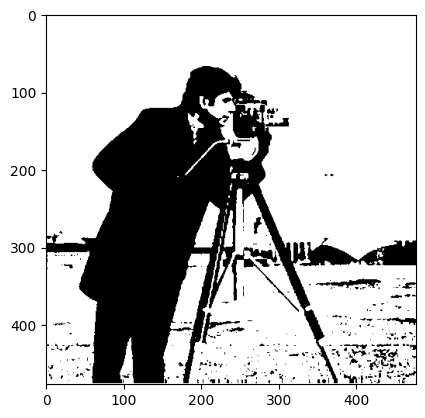

In [24]:
_, img_bin = cv.threshold(img_gray, 0.4, 1, cv.THRESH_BINARY)
plt.imshow(img_bin, "gray")

135


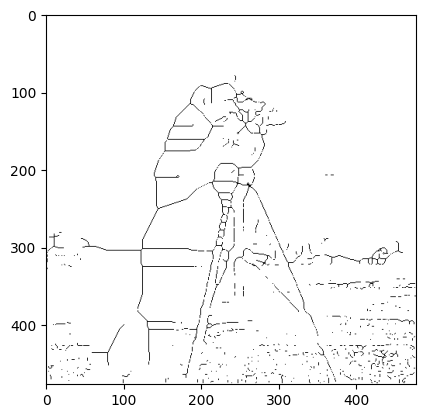

In [25]:
skel = thin(np.logical_not(img_bin).astype(np.uint8))
plt.imshow(skel, "gray")